In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(4)
import tensorflow as tf; tf.set_random_seed(4)

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = x_train.reshape((-1, 784)), x_test.reshape((-1, 784))
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)
y_train_cls = y_train.copy().astype(np.int64).reshape((-1,1))
y_test_cls = y_test.copy().astype(np.int64).reshape((-1,1))
y_train = np.eye(10)[y_train].astype(np.float32)
y_test = np.eye(10)[y_test].astype(np.float32)

In [3]:
tf.reset_default_graph()

In [4]:
def shuffle_batch(x, y, batch_size):
    rnd_idx = np.random.permutation(len(x))
    n_batches = len(x) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        yield x[batch_idx], y[batch_idx]

In [5]:
from functools import partial

def train_autoencoder(x_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg_coeff = 0.0005, 
                      seed=42,
                      hidden_activation=tf.nn.elu,
                      output_activation=tf.nn.elu):
    
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = x_train.shape[1]

        x = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        dense = partial(
            tf.layers.dense,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg_coeff))

        hidden = dense(x, n_neurons, activation=hidden_activation, name="hidden")
        outputs = dense(hidden, n_inputs, activation=output_activation, name="outputs")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - x))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            for x_batch, _ in shuffle_batch(x_train, y_train_cls, batch_size):
                feed_dict = {x: x_batch}
                sess.run(training_op, feed_dict=feed_dict)
            loss_train = reconstruction_loss.eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "Train MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={x: x_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

In [6]:
hidden_output, W1, b1, W4, b4 = train_autoencoder(x_train, 
                                                  n_neurons=300, 
                                                  n_epochs=4, 
                                                  batch_size=150,
                                                  output_activation=None)
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, 
                                      n_neurons=150, 
                                      n_epochs=4, 
                                      batch_size=150)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
0 Train MSE: 0.019094737
1 Train MSE: 0.019176789
2 Train MSE: 0.018756153
3 Train MSE: 0.019280579
0 Train MSE: 0.004640636
1 Train MSE: 0.004659481
2 Train MSE: 0.004521797
3 Train MSE: 0.0045601134


In [7]:
tf.reset_default_graph()

n_inputs = 28*28

x = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(x @ W1 + b1)
hidden2 = tf.nn.elu(hidden1 @ W2 + b2)
hidden3 = tf.nn.elu(hidden2 @ W3 + b3)
outputs = hidden3 @ W4 + b4

In [8]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [9]:
def show_reconstructed_digits(model_path=None, n_test_digits=2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        x_test_ = x_test[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={x: x_test_})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(x_test_[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

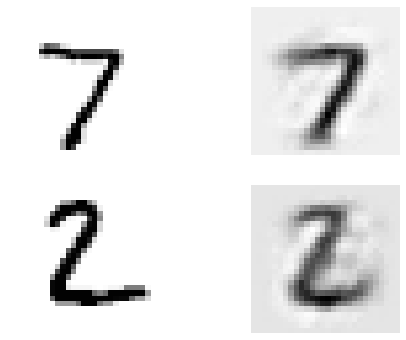

In [10]:
show_reconstructed_digits()